## Tic-Tac-Toe Agent
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
- Defining epsilon-greedy strategy
- Tracking state-action pairs for convergence
- Define hyperparameters for the Q-learning algorithm
- Generating episode and applying Q-update equation
- Checking convergence in Q-values

#### Importing libraries and TicTacToe environment

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan', 'x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    if state1 not in Q_dict.keys():
        valid_act = valid_actions(state)
        for action in valid_act:
            Q_dict[state1][action] = 0

### Epsilon-Greedy Strategy

#### Epsilon - decay check

In [5]:
max_epsilon = 1.0
min_epsilon = 0.001
_time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

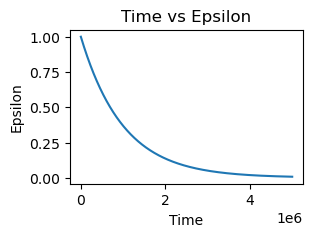

In [6]:
plt.figure(figsize=(3,2))
plt.plot(_time, epsilon)
plt.title('Time vs Epsilon')
plt.xlabel('Time')
plt.ylabel('Epsilon')
plt.show()

In [7]:
# Defining the same epsilon-greedy policy as shown above.
def epsilon_greedy(state, episode):
    state1 = Q_state(state)
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001 * episode)

    z = np.random.random()
    if z > epsilon:
        action = max(Q_dict[state1], key=Q_dict[state1].get) # Exploitation
        counter['exploit'] += 1
    else:
        allowed_actions = [action for action in env.action_space(state)[0]]
        action = allowed_actions[np.random.randint(0, len(allowed_actions))] # Exploration
        counter['explore'] += 1
    return action

#### Tracking the state-action pairs for checking convergence

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [9]:
# Define a function to initialise states to be tracked.
# All the states indicates that if an agent takes the next action, agent wins! 
def initialise_tracking_states():
    sample_q_values = [
        ['6-5-x-x-7-x-x-x-8', (7, 3)],
        ['6-x-9-x-x-3-4-x-x', (3, 5)],
        ['x-x-8-5-x-7-4-x-x', (4, 3)],
        ['8-x-x-6-5-7-x-x-x', (6, 1)],
        ['5-1-4-x-x-3-x-6-2', (6, 7)],
        ['x-2-x-3-x-5-x-4-x', (4, 9)],
        ['x-2-x-5-6-1-x-x-x', (7, 7)]
    ]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [10]:
# Initialise states to be tracked
initialise_tracking_states()

In [11]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# Defining a function to get the saved Q-dictionary from a pickle file
def get_saved_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [13]:
# Defining a function to save the state-action pair
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

### Define hyperparameters

In [14]:
EPISODES = 5000000
LR = 0.01
GAMMA = 0.95

counter = {
    'won': 0,
    'lost': 0,
    'tie': 0,
    'explore': 0,
    'exploit': 0
}

### Q-update loop

In [15]:
start_time = time.time()
for episode in range(EPISODES):
    env = TicTacToe()
    curr_state = env.state
    while not env.is_terminal(curr_state)[0]:
        curr_state1 = Q_state(curr_state)
        add_to_dict(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, terminal_flag = env.step(curr_state, curr_action)
        if terminal_flag:
            q_value = 0
            if reward == 10:
                counter['won'] += 1
            elif reward == -10:
                counter['lost'] += 1
            elif reward == 0:
                counter['tie'] += 1
        else:
            add_to_dict(next_state)
            next_state1 = Q_state(next_state)
            next_max = max(Q_dict[next_state1], key=Q_dict[next_state1].get)
            q_value = (Q_dict[next_state1][next_max])
        Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA * q_value) - Q_dict[curr_state1][curr_action]))
        
        # Update current state as next state and continue the game
        curr_state = next_state
        
    # Save tracking status after every 50,000 episodes
    if (episode + 1) % 50000 == 0:
        save_tracking_states()
        print('Episodes: {} -> Won: {}, Lost: {}, Tie: {}, Explore: {}, Exploit: {}'.format(
            episode + 1, counter['won'], counter['lost'], counter['tie'], counter['explore'], counter['exploit']
        ))
        counter = {
            'won': 0,
            'lost': 0,
            'tie': 0,
            'explore': 0,
            'exploit': 0
        }
    
elapsed_time = time.time() - start_time
save_obj(States_track, 'States_Tracked')
save_obj(Q_dict, 'Policy')

print('Time taken to complete all the episodes is {} seconds.'.format(round(elapsed_time)))

Episodes: 50000 -> Won: 12674, Lost: 14313, Tie: 23013, Explore: 212942, Exploit: 5421
Episodes: 100000 -> Won: 12524, Lost: 14128, Tie: 23348, Explore: 203104, Exploit: 15798
Episodes: 150000 -> Won: 12719, Lost: 14255, Tie: 23026, Explore: 192815, Exploit: 25523
Episodes: 200000 -> Won: 12746, Lost: 14214, Tie: 23040, Explore: 183617, Exploit: 34735
Episodes: 250000 -> Won: 13134, Lost: 13878, Tie: 22988, Explore: 174782, Exploit: 43662
Episodes: 300000 -> Won: 13014, Lost: 14043, Tie: 22943, Explore: 165657, Exploit: 52320
Episodes: 350000 -> Won: 13465, Lost: 13813, Tie: 22722, Explore: 157319, Exploit: 60305
Episodes: 400000 -> Won: 13598, Lost: 13530, Tie: 22872, Explore: 149803, Exploit: 67851
Episodes: 450000 -> Won: 13970, Lost: 13500, Tie: 22530, Explore: 142280, Exploit: 74879
Episodes: 500000 -> Won: 14274, Lost: 13144, Tie: 22582, Explore: 134886, Exploit: 82250
Episodes: 550000 -> Won: 14615, Lost: 13174, Tie: 22211, Explore: 128165, Exploit: 88126
Episodes: 600000 -> Won

Episodes: 4750000 -> Won: 46772, Lost: 749, Tie: 2479, Explore: 1668, Exploit: 164789
Episodes: 4800000 -> Won: 46805, Lost: 694, Tie: 2501, Explore: 1603, Exploit: 164777
Episodes: 4850000 -> Won: 46903, Lost: 686, Tie: 2411, Explore: 1465, Exploit: 164708
Episodes: 4900000 -> Won: 46808, Lost: 713, Tie: 2479, Explore: 1495, Exploit: 164930
Episodes: 4950000 -> Won: 46894, Lost: 664, Tie: 2442, Explore: 1446, Exploit: 164829
Episodes: 5000000 -> Won: 47049, Lost: 652, Tie: 2299, Explore: 1339, Exploit: 164811
Time taken to complete all the episodes is 2445 seconds.


**Observations:**
- As observed for every 50,000 episodes, the winning percentage increases for an agent and losing/tie percentage gradually comes down.
- Initially, the agent tries to explore more and as the time decays, the agent tries to exploit from the existing knowledge base.
- To run 5M episodes, it approximately takes 45 minutes.

In [16]:
States_track

defaultdict(dict,
            {'6-5-x-x-7-x-x-x-8': {(7, 3): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0.1,
               0.1,
               0.1,
               0.199,
               0.199,
               0.199,
               0.199,
             

#### Check the Q-dictionary

In [17]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.918574094602475,
              (0, 3): -0.7471787897985788,
              (0, 5): -1.389714459297634,
              (0, 7): -1.1354231055327715,
              (0, 9): -0.702445424811452,
              (1, 1): -1.2718553844774494,
              (1, 3): -1.2879466450257704,
              (1, 5): 6.0634925714572585,
              (1, 7): -1.3302918691818064,
              (1, 9): -1.3668522930679416,
              (2, 1): -0.8711006349749014,
              (2, 3): -0.9658339442508554,
              (2, 5): -1.3770710079404804,
              (2, 7): -0.947076074354038,
              (2, 9): 0.43628694234700854,
              (3, 1): -1.3682102982910485,
              (3, 3): -1.311752420932955,
              (3, 5): -1.2837175164653212,
              (3, 7): -1.2276012867167077,
              (3, 9): -1.2873817990633731,
              (4, 1): -1.3436143448273474,
              (4, 3): -1.3404413835788205,
              (4, 5):

In [18]:
len(Q_dict)

1732298

In [19]:
# Try checking for one of the states - that which action your agent thinks is the best
# Current State: 6-x-9-x-x-3-4-x-x
# Ideal action which agent should take in order to win the game: (3, 5)
# NOTE: Loading the pickle files which is originally saved from the experiment performed for few states.
saved_q_dict = get_saved_obj('./Saved_Policy.pkl')
saved_states_track = get_saved_obj('./Saved_States_Tracked.pkl')
sample_state = '6-x-9-x-x-3-4-x-x'
max(saved_q_dict.get(sample_state), key=saved_q_dict.get(sample_state).get)

(3, 5)

#### Check the states tracked for Q-values convergence
(non-evaluative)

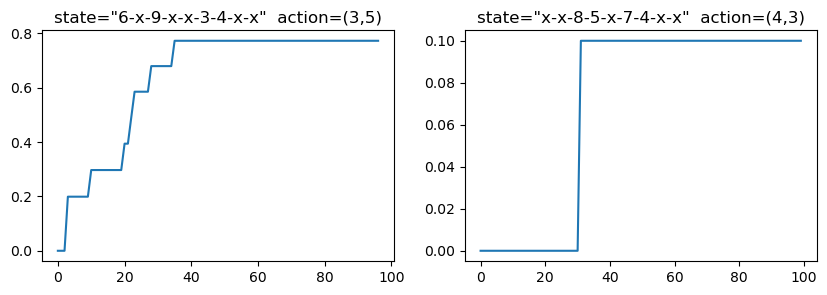

In [20]:
# Write the code for plotting the graphs for state-action pairs tracked
values1 = saved_states_track.get(sample_state).get((3, 5))
values2 = saved_states_track.get('x-x-8-5-x-7-4-x-x').get((4, 3))
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.asarray(range(0, len(values1))), values1)
plt.title('state="' + sample_state + '"  action=(3,5)')

plt.subplot(122)
plt.plot(np.asarray(range(0, len(values2))), values2)
plt.title('state="x-x-8-5-x-7-4-x-x"  action=(4,3)')
plt.show()

**Observations:** For both the state and action pairs, approximately after 2M episodes, we are getting the max q-value